<a href="https://colab.research.google.com/github/AvantiShri/gcp_analysis_rough/blob/main/cleaner/BulkAnalyze_maxsmooth_timedomain.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import matplotlib
from matplotlib import pyplot as plt
from IPython.display import Image
import scipy
import time

def max_and_maxabs_over_smoothing_windows_1darr(arr, windowsize):
  arr_cumsum = np.array([0] + list(np.cumsum(arr)))
  #under the hypothesis of white noise, each entry is iid. Let v represent
  # the variance of each power. The variance of the sum in a window
  # is v*window, so the variances across different window sizes can be
  # normalized by dividing by sqrt(window).
  arr_normalized = (arr_cumsum[windowsize:]
                    - arr_cumsum[:-windowsize])/np.sqrt(windowsize)
  return np.max(arr_normalized), np.max(np.abs(arr_normalized))

def max_and_maxabs_over_different_smoothing_windows_2darr(arrs, windowsize):
  arrs_cumsum = np.pad(np.cumsum(arrs, axis=1), ((0,0),(1,0)))
  arrs_normalized = (arrs_cumsum[:,windowsize:]
                      - arrs_cumsum[:,:-windowsize])/np.sqrt(windowsize)
  return np.max(arrs_normalized, axis=1), np.max(np.abs(arrs_normalized), axis=1)

def perform_analysis(values, num_permutations):

  toreturndict = {}

  start = time.time()
  rng = np.random.RandomState(1234)
  rng_permutations = np.array([rng.permutation(values)
                               for i in range(num_permutations)])

  windowsizes = [60, 300, 600, 900]

  for windowsize in windowsizes:
    max, maxabs = max_and_maxabs_over_smoothing_windows_1darr(values, windowsize)
    max_permute, maxabs_permute = max_and_maxabs_over_different_smoothing_windows_2darr(rng_permutations, windowsize)
    pval_max = np.mean(max_permute >= max)
    pval_maxabs = np.mean(maxabs_permute >= maxabs)
    toreturndict['pval_maxwindow'+str(windowsize)] = pval_max
    toreturndict['val_maxwindow'+str(windowsize)] = max
    toreturndict['pval_maxabswindow'+str(windowsize)] = pval_maxabs
    toreturndict['val_maxabswindow'+str(windowsize)] = maxabs

  return toreturndict

In [ ]:
def get_chisquareminus1(egg_values):
  #print("Num nan:", np.sum(np.isnan(egg_values)))
  #Radin 2023 (Anomalous entropic effects in physical systems associated
  # with collective consciousness) said "All individual samples within a matrix
  # less than 55 or greater than 145 were set to nan" so we do that here
  egg_values = np.where((egg_values < 55), np.nan, egg_values)
  egg_values = np.where((egg_values > 145), np.nan, egg_values)
  #print("Num nan post mask:", np.sum(np.isnan(egg_values)))

  num_nonnan_eggs = np.sum(np.isnan(egg_values)==False, axis=1) #get the number of non NaN eggs per row
  #If any rows are all-nan, aboort as if we dropped that row it would mess
  # up the temporal spacing
  #assert (np.sum(num_nonnan_eggs==0)==0), np.sum(num_nonnan_eggs==0)

  sum_eggs = np.nansum(egg_values, axis=1) #get the sum across all eggs - NaNs are automatically skipped
  z_sum_eggs = (sum_eggs - num_nonnan_eggs*100)/np.sqrt(num_nonnan_eggs*200*0.25) #get z scores as per a binomial dist

  return np.square(z_sum_eggs)-1, z_sum_eggs

In [ ]:
#mount google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import json
event_metadata_list = json.load(open("/content/drive/MyDrive/GCP_data/event_metadata_list.json"))

In [ ]:
%matplotlib inline

import glob
import json
import numpy as np
import scipy
import os
from matplotlib import pyplot as plt
import time

%cd /content/drive/MyDrive/GCP_data/

NUM_PERMUTATIONS = 1000

generalstats = {"test": [], "control1": [], "control2": [], "control3": [],
                "control4": [], "control5": [], "control6": []}
csm1_psanalysis = {"test": [], "control1": [], "control2": [], "control3": [],
                   "control4": [], "control5": [], "control6": []}
compositez_psanalysis = {"test": [], "control1": [], "control2": [],
                         "control3": [], "control4": [], "control5": [], "control6": []}

event_count = 0

dont_rerun_if_cache_file_exists = True #If False, rerun the call the perform_powerspectrum_analysis
cachesavefolder = "/content/drive/MyDrive/GCP_data/analysis/maxandmaxabswindow/"
!mkdir $cachesavefolder

for (event, event_name, pval) in event_metadata_list[:]:

  event_count += 1
  print("\n--------------------------------")
  print("Event Count:",event_count,event,event_name,pval)

  for spanname in ['test', 'control1', 'control2']:#, 'control3', 'control4', 'control5', 'control6']:
    print("span:", spanname)
    egg_values = np.load("extracted/"+event+"_"+spanname+"_eggvalues.npy")

    csm1, z_sum_eggs = get_chisquareminus1(egg_values)

    csm1_zscore = np.sum(csm1)/np.sqrt(2*len(csm1)) #variance of chi-squared with df=1 is 2

    spangeneralstats = {
      'csm1_zscore': csm1_zscore,
      'length': len(csm1)}
    generalstats[spanname].append(spangeneralstats)

    print(spanname, spangeneralstats)

    for signaltype,signal,signalsavedict in [("csm1", csm1, csm1_psanalysis),
                                             ("compositez", z_sum_eggs, compositez_psanalysis)
                                             ]:
      start = time.time()
      saveprefix = cachesavefolder+"/"+event+"_"+spanname+"_"+signaltype+"_nperm-"+str(NUM_PERMUTATIONS)
      if (dont_rerun_if_cache_file_exists and os.path.exists(saveprefix+"_psanalysis.json")):
        ps_analysis = json.load(open(saveprefix+"_psanalysis.json"))
      else:
        ps_analysis = perform_analysis(signal, NUM_PERMUTATIONS)
        open(saveprefix+"_psanalysis.json",'w').write(json.dumps(ps_analysis))
      print(signaltype, ps_analysis, time.time()-start)
      signalsavedict[spanname].append(ps_analysis)

Streaming output truncated to the last 5000 lines.
compositez {'pval_maxwindow60': 0.478, 'val_maxwindow60': 3.4966742050774373, 'pval_maxabswindow60': 0.441, 'val_maxabswindow60': 3.768380878367319, 'pval_maxwindow300': 0.907, 'val_maxwindow300': 2.4724792974498517, 'pval_maxabswindow300': 0.98, 'val_maxabswindow300': 2.6822917233009695, 'pval_maxwindow600': 0.584, 'val_maxwindow600': 2.521666666666661, 'pval_maxabswindow600': 0.953, 'val_maxabswindow600': 2.5474999999999985, 'pval_maxwindow900': 0.784, 'val_maxwindow900': 2.1085808192056508, 'pval_maxabswindow900': 0.976, 'val_maxabswindow900': 2.294236870917902} 1.797748327255249
span: control2
control2 {'csm1_zscore': 0.012783820260007624, 'length': 21600}
csm1 {'pval_maxwindow60': 0.901, 'val_maxwindow60': 5.136619699816817, 'pval_maxabswindow60': 0.901, 'val_maxabswindow60': 5.136619699816817, 'pval_maxwindow300': 0.985, 'val_maxwindow300': 3.513032050451572, 'pval_maxabswindow300': 0.925, 'val_maxabswindow300': 4.005138190268457

In [ ]:
import json

prefix = "/content/drive/MyDrive/GCP_data/analysis/nperm"+str(NUM_PERMUTATIONS)+"_maxandmaxabswindow_controls1and2"

#save the results
open(prefix+"_csm1_psanalysis.json","w").write(json.dumps(csm1_psanalysis, indent=4))
open(prefix+"_compositez_psanalysis.json","w").write(json.dumps(compositez_psanalysis, indent=4))

In [1]:
#mount google drive
from google.colab import drive
drive.mount('/content/drive')

%cd /content/drive/MyDrive/GCP_data

Mounted at /content/drive
/content/drive/MyDrive/GCP_data


In [2]:
import json
import numpy as np
import scipy

NUM_PERMUTATIONS = 1000

#load the pvals in case we want to remake the plots without rerunning the prev stuff
prefix = "/content/drive/MyDrive/GCP_data/analysis/nperm"+str(NUM_PERMUTATIONS)+"_maxandmaxabswindow_controls1and2"

event_metadata_list = json.load(open("/content/drive/MyDrive/GCP_data/event_metadata_list.json"))
#generalstats = json.load(open("/content/drive/MyDrive/GCP_data/analysis/generalstats.json"))

csm1_psanalysis = json.load(open(prefix+"_csm1_psanalysis.json"))
compositez_psanalysis = json.load(open(prefix+"_compositez_psanalysis.json"))

In [3]:
import os

def get_meta_pval(pvals):
  chisquare_stat = -2*np.sum(np.log(pvals))
  deg_freedom = 2*len(pvals)
  return (1 - scipy.stats.chi2.cdf(chisquare_stat, df=deg_freedom))

def get_iterative_metapvals(pvals):
 return np.array([(get_meta_pval(pvals[:i+1])) for i in range(len(pvals))])

metatrends_to_sim = 5000
rng = np.random.RandomState(1234)
savefile = "/content/drive/MyDrive/GCP_data/analysis/simulated_metatrends_nperm"+str(metatrends_to_sim)+".npy"
if (os.path.isfile(savefile)):
  simulated_metapvals_arr = np.load(savefile)
else:
  simulated_metapvals_arr = np.array([
      get_iterative_metapvals(
        np.maximum(rng.uniform(size=len(csm1_psanalysis["test"])),
                  1.0/NUM_PERMUTATIONS)
      )
        for i in range(metatrends_to_sim)])
  np.save(savefile, simulated_metapvals_arr)

In [4]:
import matplotlib
from matplotlib import pyplot as plt
from matplotlib import patches as mpatches
from IPython.core.display import Image, display

#plot how the meta pvalue changes with samples

min_meta = 1 # start the x axis here, min num to include in metaanalysis
max_meta = len(csm1_psanalysis["test"]) #where to stop the plot

def correct_pvals(pvals, m): #permutation p values should never be zero: https://www.degruyter.com/document/doi/10.2202/1544-6115.1585/html
  #'Let B be the number of times out of m that t_sim >= t_obs'
  Bs = pvals*m
  #Under the null hypothesis, B is uniformly distributed across all integers
  # ranging from 0 to m, and the probability of observing B <= b is (b+1)/(m+1)
  adjusted_pvals = (Bs+1)/(m+1)
  return adjusted_pvals

original_gcp_pvals = np.array([x[2] for x in event_metadata_list[:max_meta]])

def make_meta_trend_plot(title, uncorrected_pvals_loa, loa_names, loa_colors):
  %matplotlib inline

  xaxis_slice = list(range(min_meta,max_meta+1))
  xaxis_full = list(range(1,max_meta+1))

  pvals_loa = [correct_pvals(arr, m=NUM_PERMUTATIONS) for arr in uncorrected_pvals_loa]
  metapvals_loa = [get_iterative_metapvals(arr) for arr in pvals_loa]

  theslice = slice(min_meta-1, max_meta)
  min_simmetapvals_arr = np.min(simulated_metapvals_arr[:,theslice], axis=1)

  pvalformetapvals_list = [correct_pvals(np.mean(min_simmetapvals_arr <= np.min(arr)),
                                         m=len(simulated_metapvals_arr))
                            for arr in metapvals_loa]

  pvalforrankbias_list = [
      scipy.stats.mannwhitneyu(x=arr[original_gcp_pvals < 0.5],
                               y=arr[original_gcp_pvals >= 0.5], alternative='less')[1]
      for arr in pvals_loa
  ]
  print("Testing for low meta-analysis p-values:")
  for arr_name, metatrendpval, rankbiaspval in zip(loa_names, pvalformetapvals_list, pvalforrankbias_list):
    print("meta-analysis p-value:",arr_name,"pval:",metatrendpval)
    print("Rankbias p-value:",arr_name,"pval:",rankbiaspval)

  #Plot meta-analysis trends for the original pvalues
  fig = plt.figure(figsize=(15,4))
  handles = []

  plt.plot([min_meta, max_meta], -np.log10([np.percentile(min_simmetapvals_arr, 5)]*2), color="black", linestyle="--")
  plt.plot(xaxis_full, -np.log10(original_gcp_pvals), color="black")
  handles.append(mpatches.Patch(color='black', label='Original GCP -log10(pval)'))

  for pvals, metapvals, color, arr_name in zip(pvals_loa, metapvals_loa, loa_colors, loa_names):
    plt.scatter(xaxis_full, -np.log10(pvals[:max_meta]), color=color, s=1)
    plt.plot(xaxis_slice, -np.log10(metapvals[theslice]), color=color)
    handles.append(mpatches.Patch(color=color, label=arr_name))

  plt.xlabel("Event Number (top ranked first)")
  plt.ylabel("-log10 pvalue") #Z-score equivalent derived from inverse-normal-cdf(1-p)
  plt.title(title)
  plt.legend(handles=handles, loc="upper left", ncol=4)
  plt.show()

  return pvalformetapvals_list

print("num permutations:",NUM_PERMUTATIONS)

num permutations: 1000


csm1
maxwindow60
Testing for low meta-analysis p-values:
meta-analysis p-value: Original Timeperiod pval: 0.7698460307938413
Rankbias p-value: Original Timeperiod pval: 0.35475252314820027
meta-analysis p-value: 1x before pval: 0.010997800439912017
Rankbias p-value: 1x before pval: 0.26414086014844546
meta-analysis p-value: 1x after pval: 0.624875024995001
Rankbias p-value: 1x after pval: 0.5288214269323526


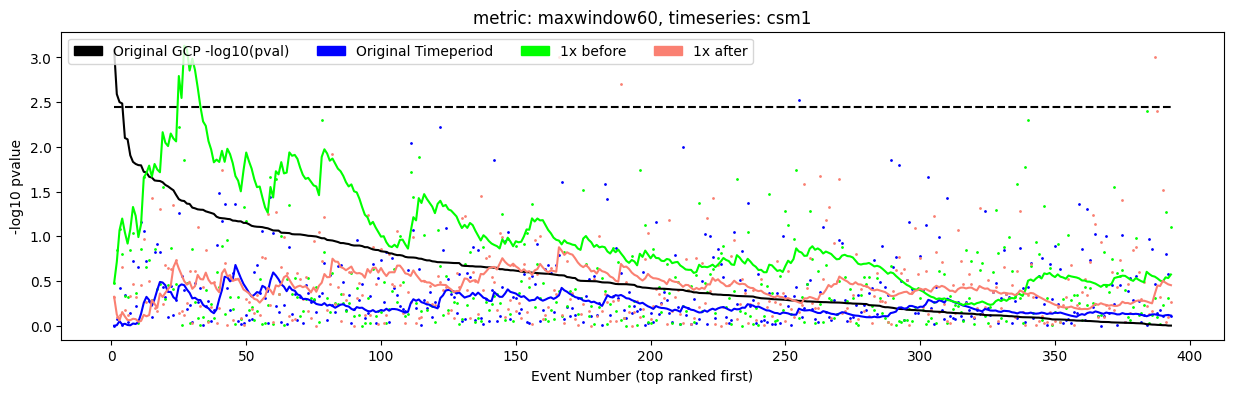

maxwindow300
Testing for low meta-analysis p-values:
meta-analysis p-value: Original Timeperiod pval: 0.8102379524095181
Rankbias p-value: Original Timeperiod pval: 0.2019321217285684
meta-analysis p-value: 1x before pval: 0.8872225554889022
Rankbias p-value: 1x before pval: 0.9690619047238335
meta-analysis p-value: 1x after pval: 0.7970405918816237
Rankbias p-value: 1x after pval: 0.40719340464906856


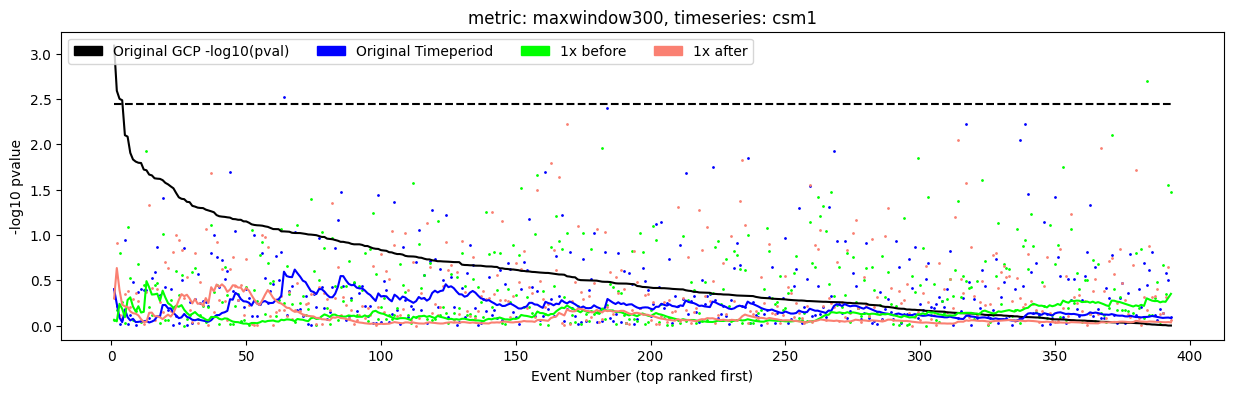

maxwindow600
Testing for low meta-analysis p-values:
meta-analysis p-value: Original Timeperiod pval: 0.7340531893621276
Rankbias p-value: Original Timeperiod pval: 0.19253141871459573
meta-analysis p-value: 1x before pval: 0.6910617876424714
Rankbias p-value: 1x before pval: 0.6164211820525543
meta-analysis p-value: 1x after pval: 0.4149170165966807
Rankbias p-value: 1x after pval: 0.26234802749172453


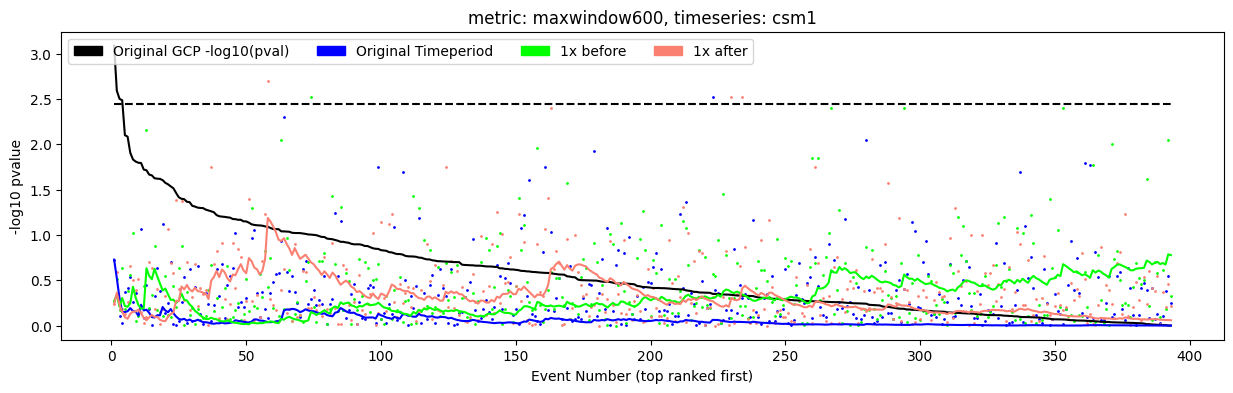

maxwindow900
Testing for low meta-analysis p-values:
meta-analysis p-value: Original Timeperiod pval: 0.8924215156968607
Rankbias p-value: Original Timeperiod pval: 0.4150262476784893
meta-analysis p-value: 1x before pval: 0.8442311537692462
Rankbias p-value: 1x before pval: 0.39533812676584246
meta-analysis p-value: 1x after pval: 0.8648270345930814
Rankbias p-value: 1x after pval: 0.7568089008066881


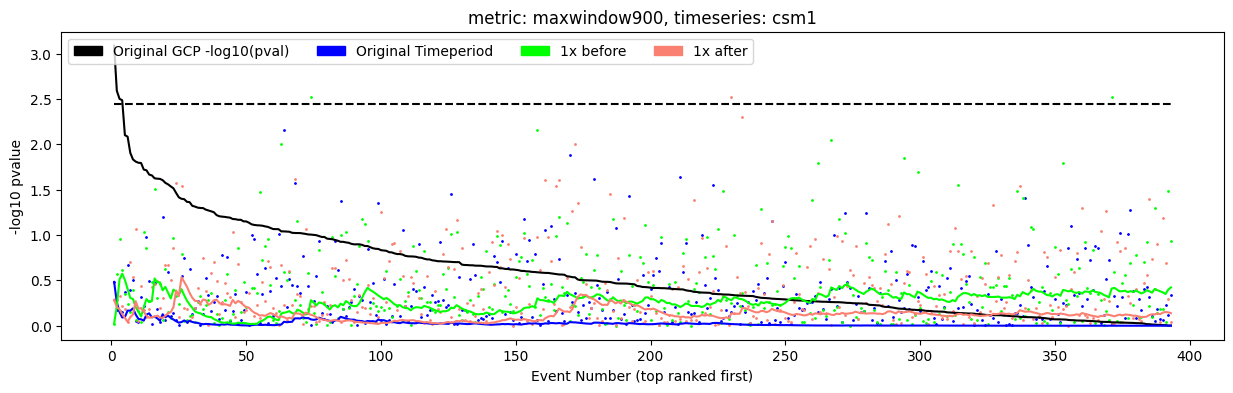

maxabswindow60
Testing for low meta-analysis p-values:
meta-analysis p-value: Original Timeperiod pval: 0.7698460307938413
Rankbias p-value: Original Timeperiod pval: 0.35016400993917973
meta-analysis p-value: 1x before pval: 0.010997800439912017
Rankbias p-value: 1x before pval: 0.27978033050647816
meta-analysis p-value: 1x after pval: 0.6312737452509498
Rankbias p-value: 1x after pval: 0.544273977141922


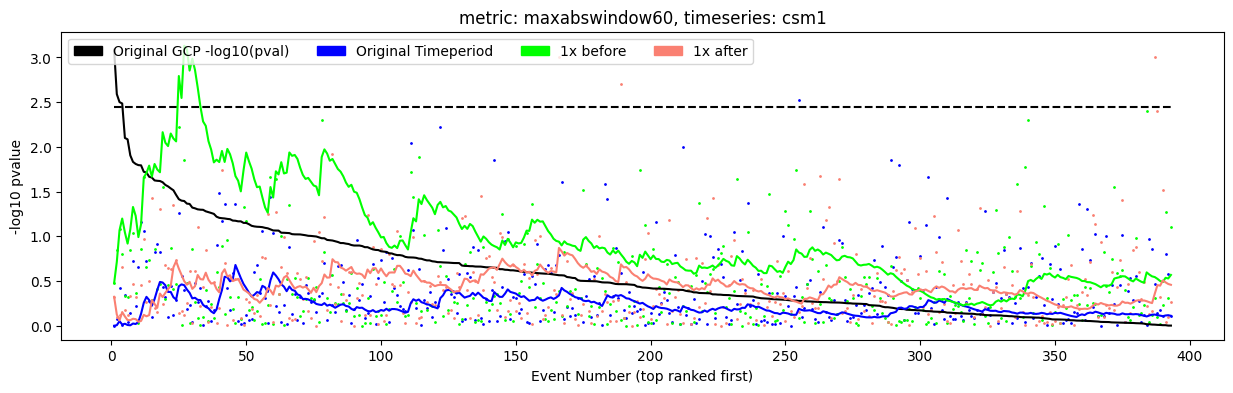

maxabswindow300
Testing for low meta-analysis p-values:
meta-analysis p-value: Original Timeperiod pval: 0.789242151569686
Rankbias p-value: Original Timeperiod pval: 0.2382039831542474
meta-analysis p-value: 1x before pval: 0.7384523095380923
Rankbias p-value: 1x before pval: 0.8169608181522408
meta-analysis p-value: 1x after pval: 0.8410317936412718
Rankbias p-value: 1x after pval: 0.708084815566708


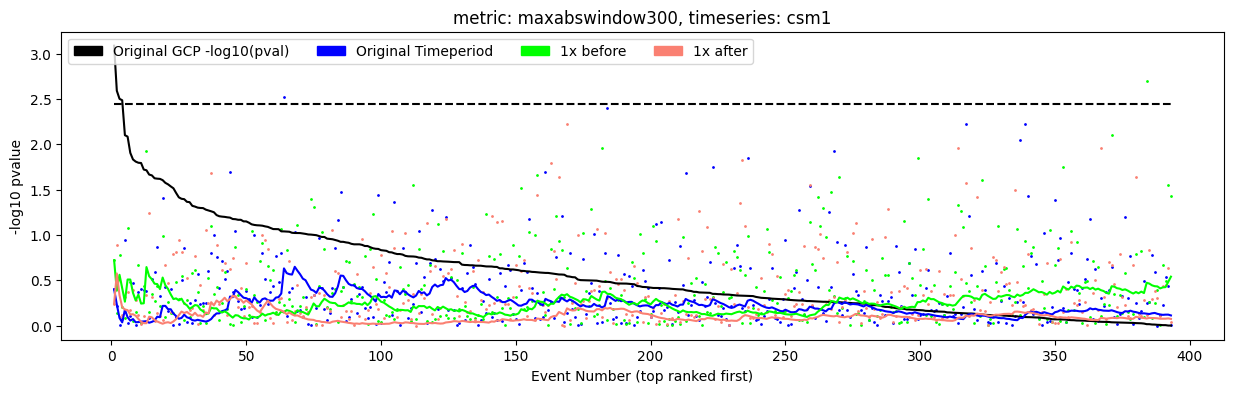

maxabswindow600
Testing for low meta-analysis p-values:
meta-analysis p-value: Original Timeperiod pval: 0.7356528694261147
Rankbias p-value: Original Timeperiod pval: 0.17537559594609126
meta-analysis p-value: 1x before pval: 0.36072785442911415
Rankbias p-value: 1x before pval: 0.18867436522271924
meta-analysis p-value: 1x after pval: 0.6074785042991403
Rankbias p-value: 1x after pval: 0.29301618964381076


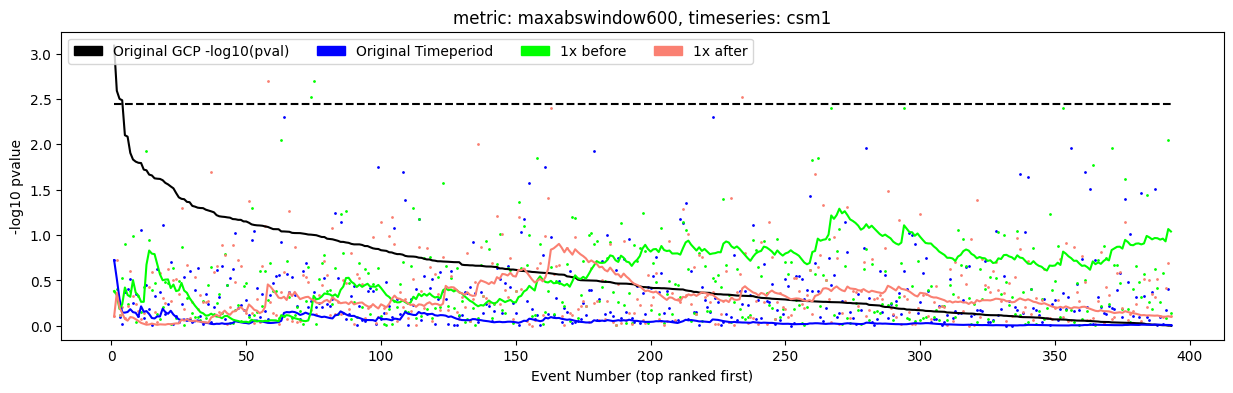

maxabswindow900
Testing for low meta-analysis p-values:
meta-analysis p-value: Original Timeperiod pval: 0.8938212357528494
Rankbias p-value: Original Timeperiod pval: 0.38988481103472283
meta-analysis p-value: 1x before pval: 0.6412717456508699
Rankbias p-value: 1x before pval: 0.29285884490528863
meta-analysis p-value: 1x after pval: 0.9934013197360528
Rankbias p-value: 1x after pval: 0.8362973918251979


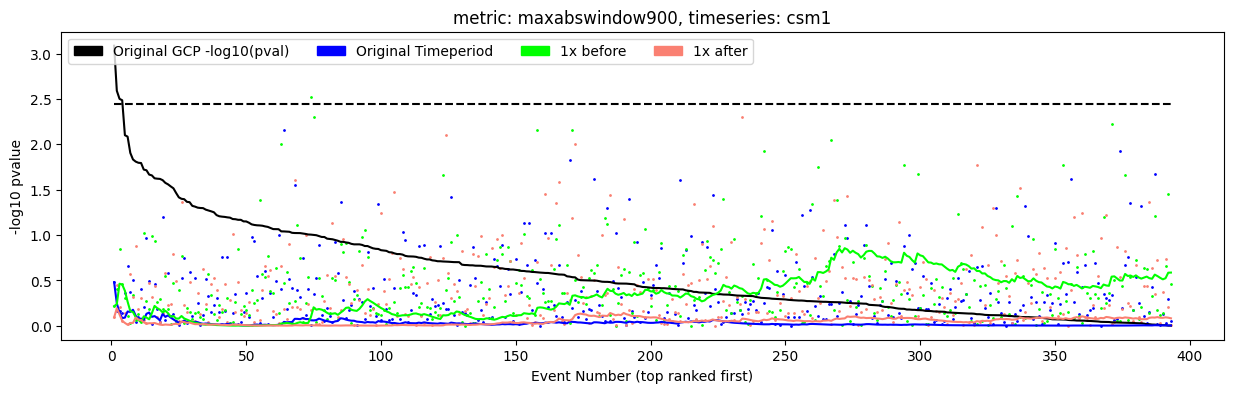

compositez
maxwindow60
Testing for low meta-analysis p-values:
meta-analysis p-value: Original Timeperiod pval: 0.5408918216356727
Rankbias p-value: Original Timeperiod pval: 0.330374546695518
meta-analysis p-value: 1x before pval: 0.6596680663867227
Rankbias p-value: 1x before pval: 0.34931679311929753
meta-analysis p-value: 1x after pval: 0.020795840831833633
Rankbias p-value: 1x after pval: 0.2106761230833123


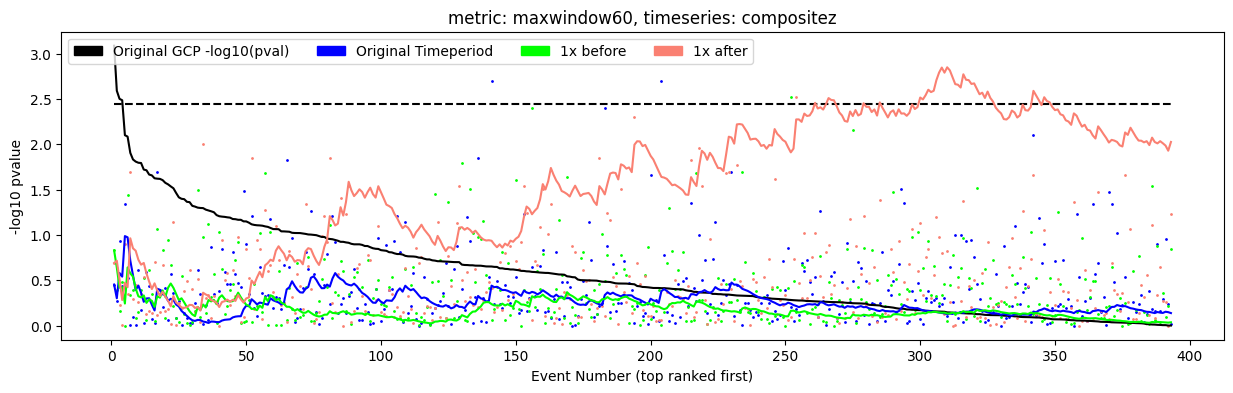

maxwindow300
Testing for low meta-analysis p-values:
meta-analysis p-value: Original Timeperiod pval: 0.9044191161767646
Rankbias p-value: Original Timeperiod pval: 0.4832082542894255
meta-analysis p-value: 1x before pval: 0.8976204759048191
Rankbias p-value: 1x before pval: 0.5177037654859524
meta-analysis p-value: 1x after pval: 0.16356728654269145
Rankbias p-value: 1x after pval: 0.11570471430079843


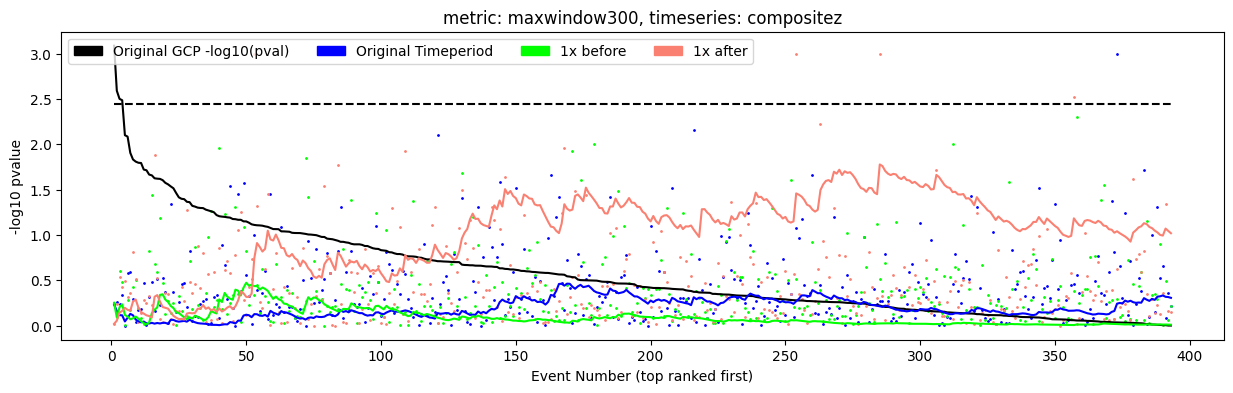

maxwindow600
Testing for low meta-analysis p-values:
meta-analysis p-value: Original Timeperiod pval: 0.3645270945810838
Rankbias p-value: Original Timeperiod pval: 0.35884885456221105
meta-analysis p-value: 1x before pval: 0.9584083183363328
Rankbias p-value: 1x before pval: 0.2300644627512864
meta-analysis p-value: 1x after pval: 0.6570685862827434
Rankbias p-value: 1x after pval: 0.33786938334073957


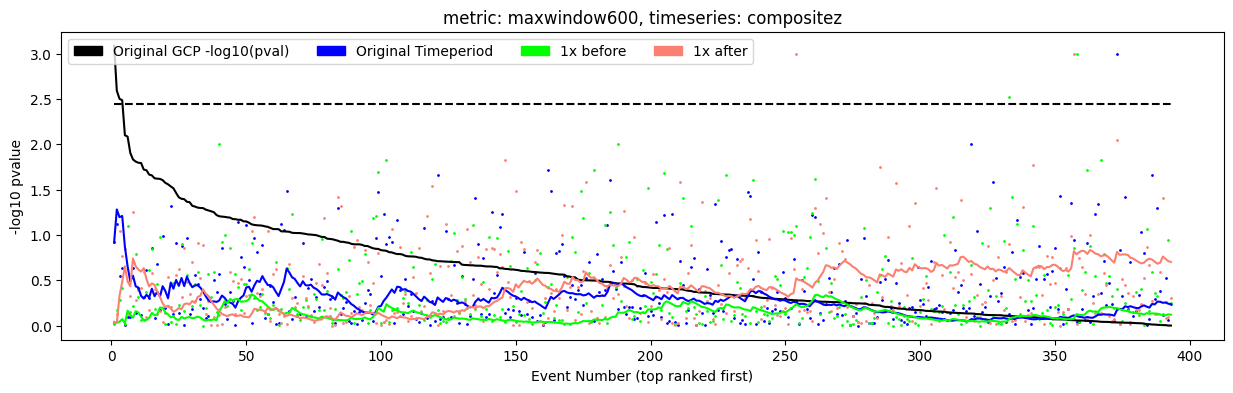

maxwindow900
Testing for low meta-analysis p-values:
meta-analysis p-value: Original Timeperiod pval: 0.7284543091381724
Rankbias p-value: Original Timeperiod pval: 0.3962196201364673
meta-analysis p-value: 1x before pval: 0.4367126574685063
Rankbias p-value: 1x before pval: 0.20477900730112414
meta-analysis p-value: 1x after pval: 0.6082783443311338
Rankbias p-value: 1x after pval: 0.6577706620667606


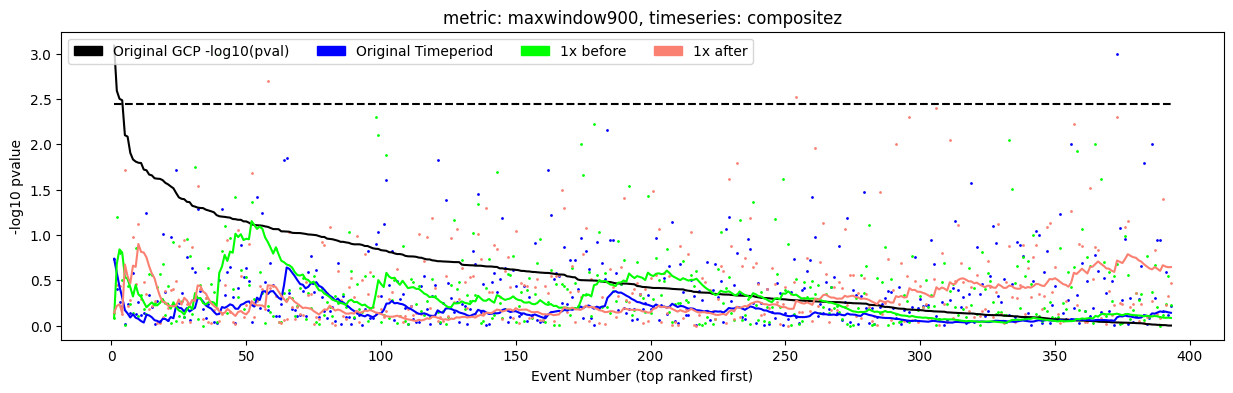

maxabswindow60
Testing for low meta-analysis p-values:
meta-analysis p-value: Original Timeperiod pval: 0.4471105778844231
Rankbias p-value: Original Timeperiod pval: 0.3345302219231291
meta-analysis p-value: 1x before pval: 0.5754849030193961
Rankbias p-value: 1x before pval: 0.49908713620108364
meta-analysis p-value: 1x after pval: 0.03239352129574085
Rankbias p-value: 1x after pval: 0.44992470893543024


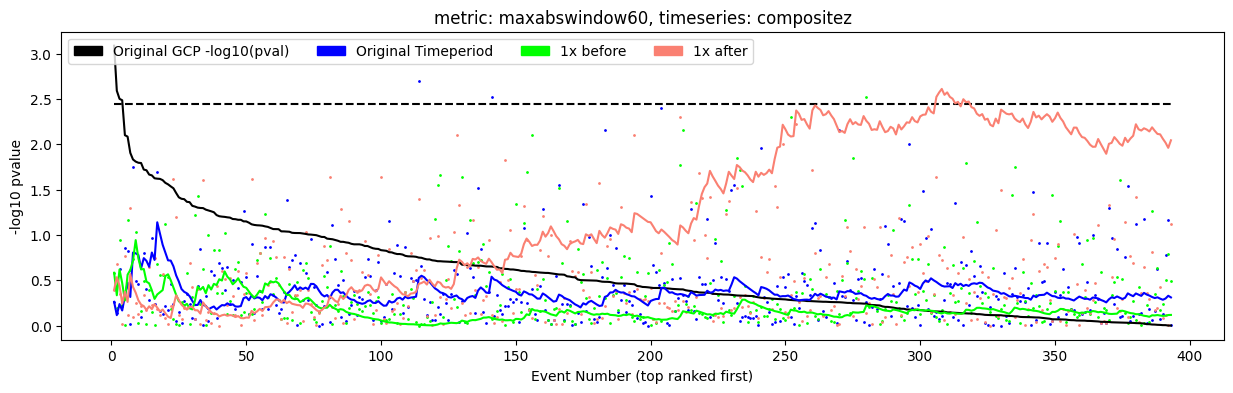

maxabswindow300
Testing for low meta-analysis p-values:
meta-analysis p-value: Original Timeperiod pval: 0.9198160367926415
Rankbias p-value: Original Timeperiod pval: 0.3420612509579639
meta-analysis p-value: 1x before pval: 0.21875624875024996
Rankbias p-value: 1x before pval: 0.29759772859909217
meta-analysis p-value: 1x after pval: 0.14417116576684663
Rankbias p-value: 1x after pval: 0.6023687390934036


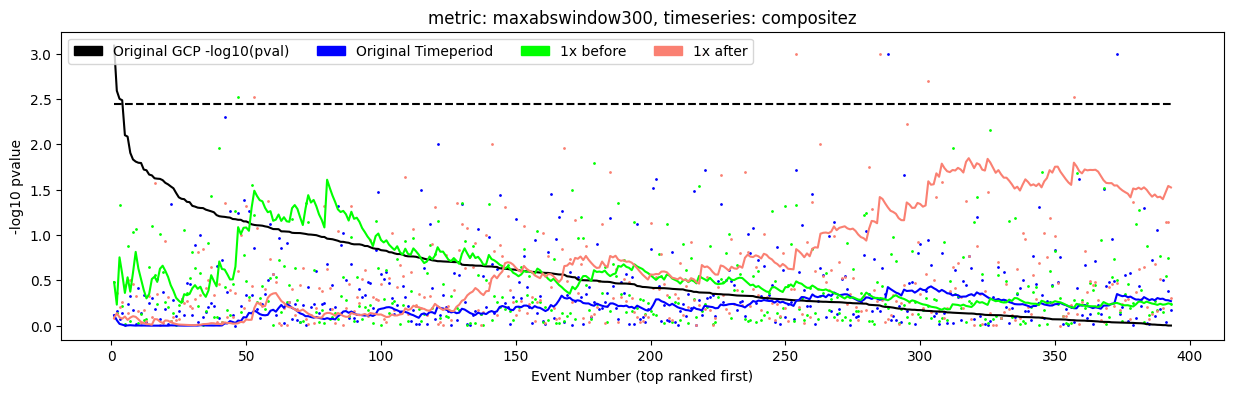

maxabswindow600
Testing for low meta-analysis p-values:
meta-analysis p-value: Original Timeperiod pval: 0.5060987802439512
Rankbias p-value: Original Timeperiod pval: 0.21133746486856603
meta-analysis p-value: 1x before pval: 0.7152569486102779
Rankbias p-value: 1x before pval: 0.04459531422274068
meta-analysis p-value: 1x after pval: 0.744251149770046
Rankbias p-value: 1x after pval: 0.9404698966199013


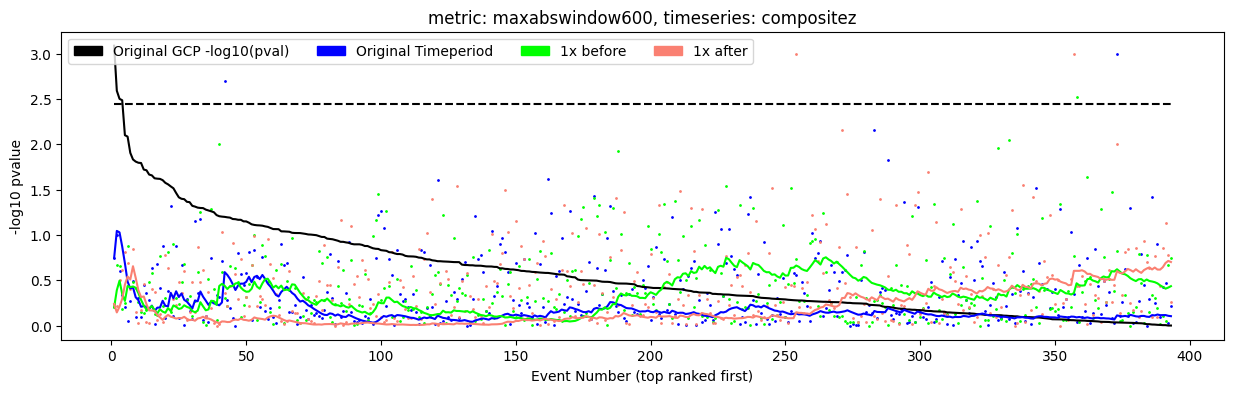

maxabswindow900
Testing for low meta-analysis p-values:
meta-analysis p-value: Original Timeperiod pval: 0.754649070185963
Rankbias p-value: Original Timeperiod pval: 0.4989045647823281
meta-analysis p-value: 1x before pval: 0.8012397520495901
Rankbias p-value: 1x before pval: 0.46644624737320295
meta-analysis p-value: 1x after pval: 0.32733453309338134
Rankbias p-value: 1x after pval: 0.686846753345289


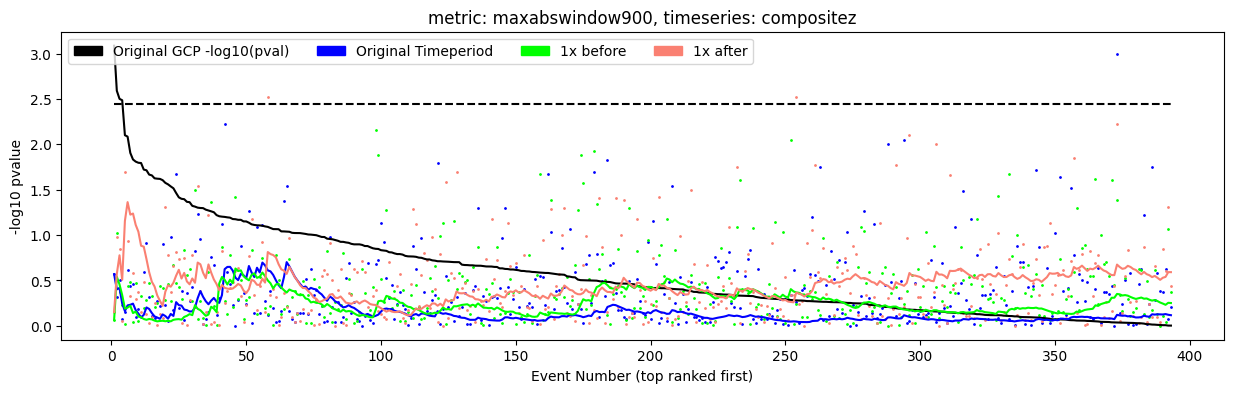

csm1
NEGATIVE maxwindow60
Testing for low meta-analysis p-values:
meta-analysis p-value: Original Timeperiod pval: 0.015796840631873626
Rankbias p-value: Original Timeperiod pval: 0.6455880875580483
meta-analysis p-value: 1x before pval: 0.8416316736652669
Rankbias p-value: 1x before pval: 0.7361583541620123
meta-analysis p-value: 1x after pval: 0.8632273545290942
Rankbias p-value: 1x after pval: 0.47154277788014676


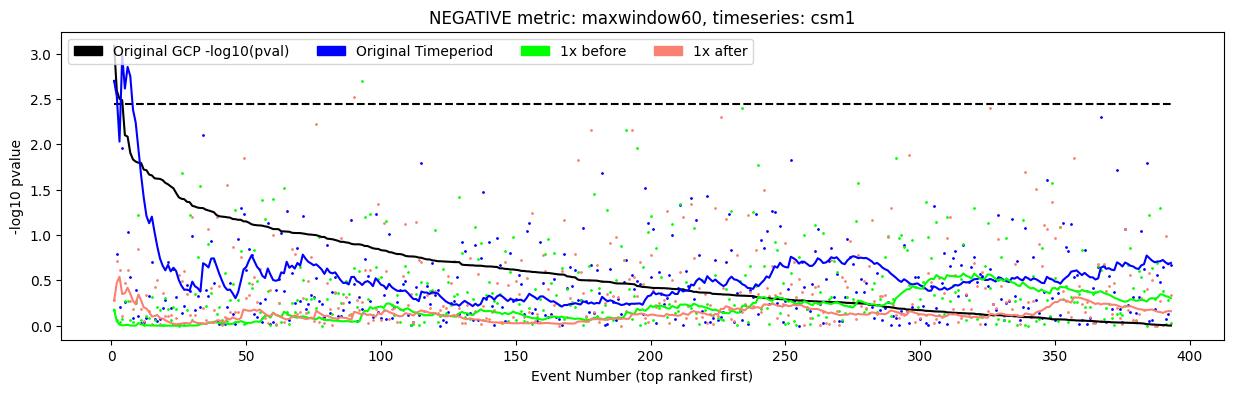

NEGATIVE maxwindow300
Testing for low meta-analysis p-values:
meta-analysis p-value: Original Timeperiod pval: 0.27274545090981805
Rankbias p-value: Original Timeperiod pval: 0.7983255069738417
meta-analysis p-value: 1x before pval: 0.23155368926214756
Rankbias p-value: 1x before pval: 0.031002036711341673
meta-analysis p-value: 1x after pval: 0.5400919816036792
Rankbias p-value: 1x after pval: 0.5931617774599288


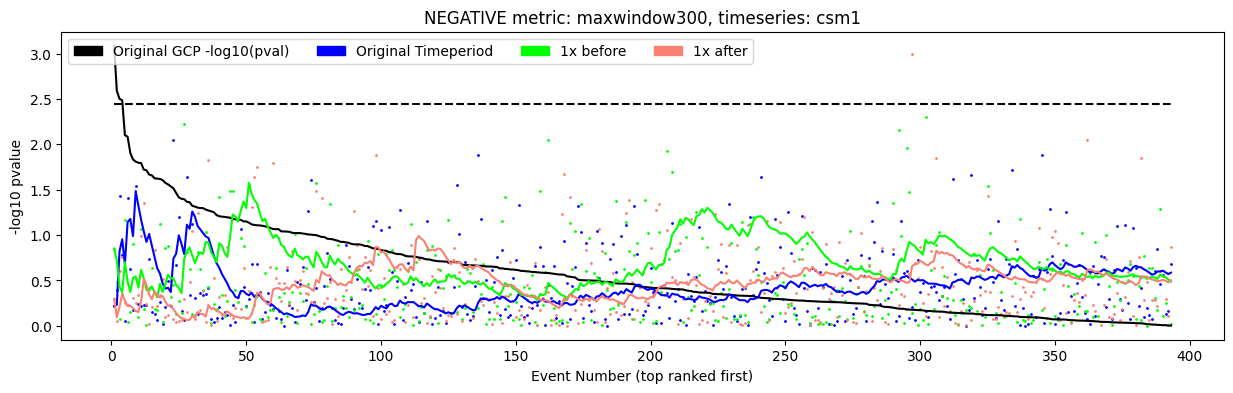

NEGATIVE maxwindow600
Testing for low meta-analysis p-values:
meta-analysis p-value: Original Timeperiod pval: 0.376124775044991
Rankbias p-value: Original Timeperiod pval: 0.8077188816545777
meta-analysis p-value: 1x before pval: 0.8894221155768847
Rankbias p-value: 1x before pval: 0.3839283505382874
meta-analysis p-value: 1x after pval: 0.6820635872825436
Rankbias p-value: 1x after pval: 0.7379501472364514


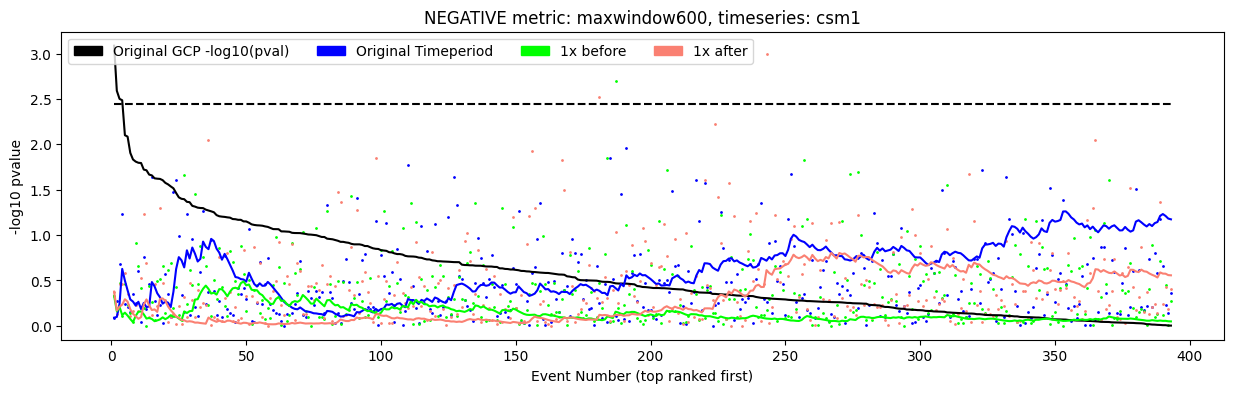

NEGATIVE maxwindow900
Testing for low meta-analysis p-values:
meta-analysis p-value: Original Timeperiod pval: 0.20535892821435714
Rankbias p-value: Original Timeperiod pval: 0.5853305483399247
meta-analysis p-value: 1x before pval: 0.34673065386922614
Rankbias p-value: 1x before pval: 0.6050143369910435
meta-analysis p-value: 1x after pval: 0.6976604679064187
Rankbias p-value: 1x after pval: 0.24347777611611332


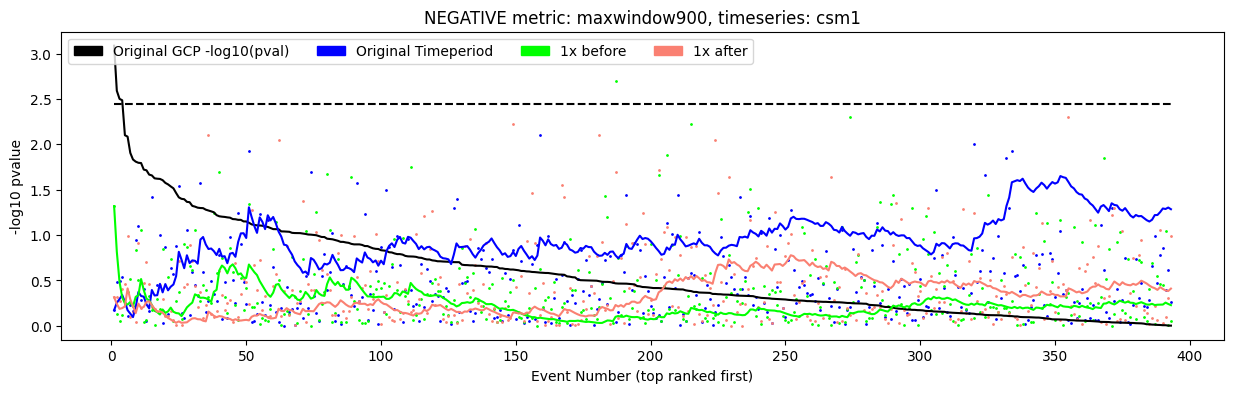

NEGATIVE maxabswindow60
Testing for low meta-analysis p-values:
meta-analysis p-value: Original Timeperiod pval: 0.015796840631873626
Rankbias p-value: Original Timeperiod pval: 0.650175009083684
meta-analysis p-value: 1x before pval: 0.8114377124575085
Rankbias p-value: 1x before pval: 0.7205275762748568
meta-analysis p-value: 1x after pval: 0.8632273545290942
Rankbias p-value: 1x after pval: 0.45608893646399046


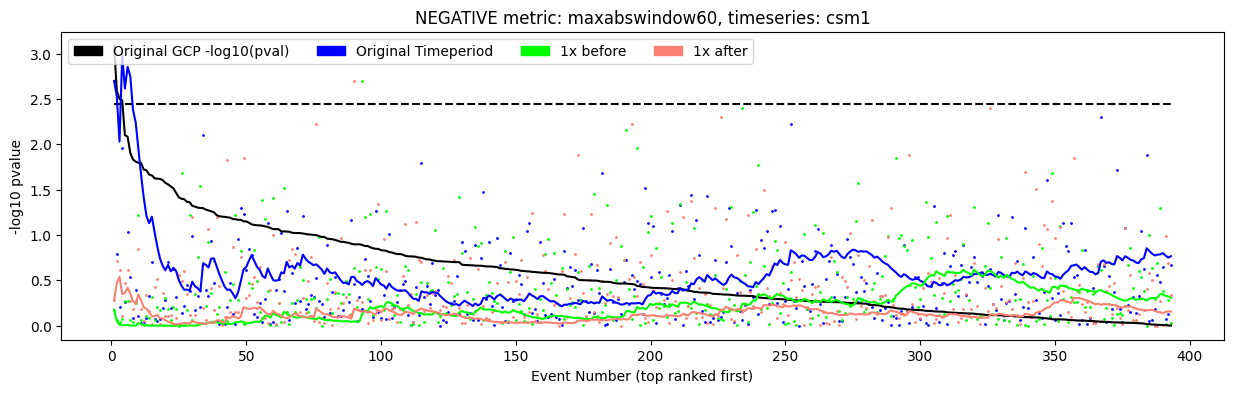

NEGATIVE maxabswindow300
Testing for low meta-analysis p-values:
meta-analysis p-value: Original Timeperiod pval: 0.23335332933413316
Rankbias p-value: Original Timeperiod pval: 0.7620792962337628
meta-analysis p-value: 1x before pval: 0.8810237952409518
Rankbias p-value: 1x before pval: 0.18328198316282218
meta-analysis p-value: 1x after pval: 0.8172365526894622
Rankbias p-value: 1x after pval: 0.2922295342781963


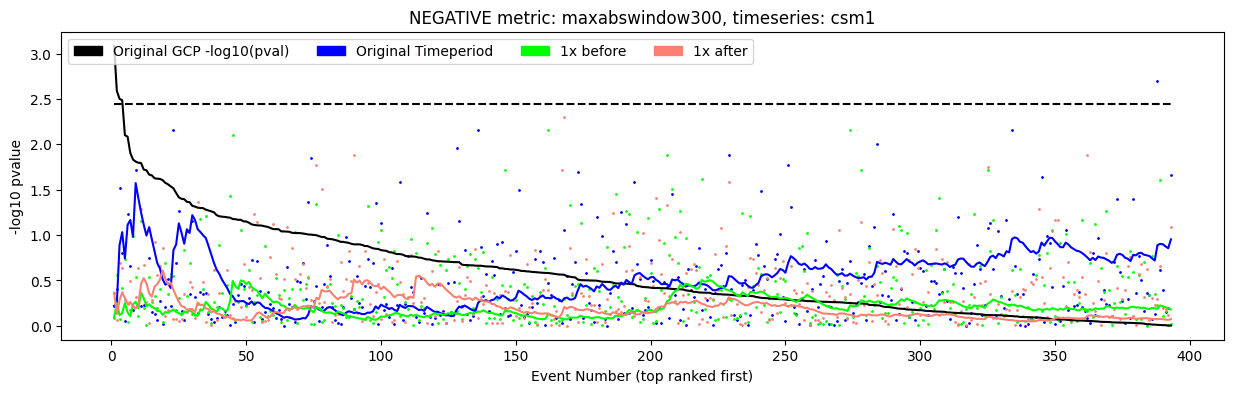

NEGATIVE maxabswindow600
Testing for low meta-analysis p-values:
meta-analysis p-value: Original Timeperiod pval: 0.4267146570685863
Rankbias p-value: Original Timeperiod pval: 0.8248605620789369
meta-analysis p-value: 1x before pval: 0.8648270345930814
Rankbias p-value: 1x before pval: 0.8115728431318783
meta-analysis p-value: 1x after pval: 0.7728454309138172
Rankbias p-value: 1x after pval: 0.7072985532163403


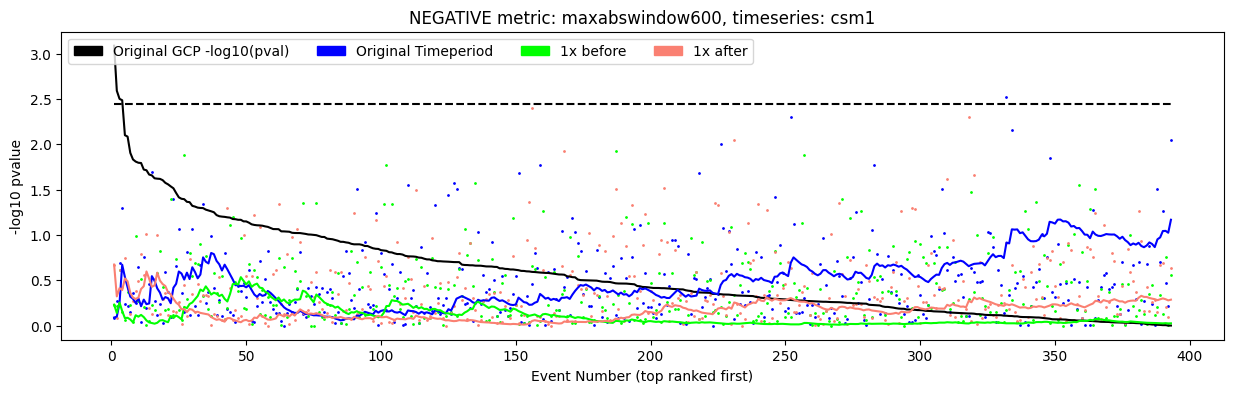

NEGATIVE maxabswindow900
Testing for low meta-analysis p-values:
meta-analysis p-value: Original Timeperiod pval: 0.2619476104779044
Rankbias p-value: Original Timeperiod pval: 0.6104662901021626
meta-analysis p-value: 1x before pval: 0.5720855828834233
Rankbias p-value: 1x before pval: 0.70745581936792
meta-analysis p-value: 1x after pval: 0.4761047790441912
Rankbias p-value: 1x after pval: 0.16392875329940254


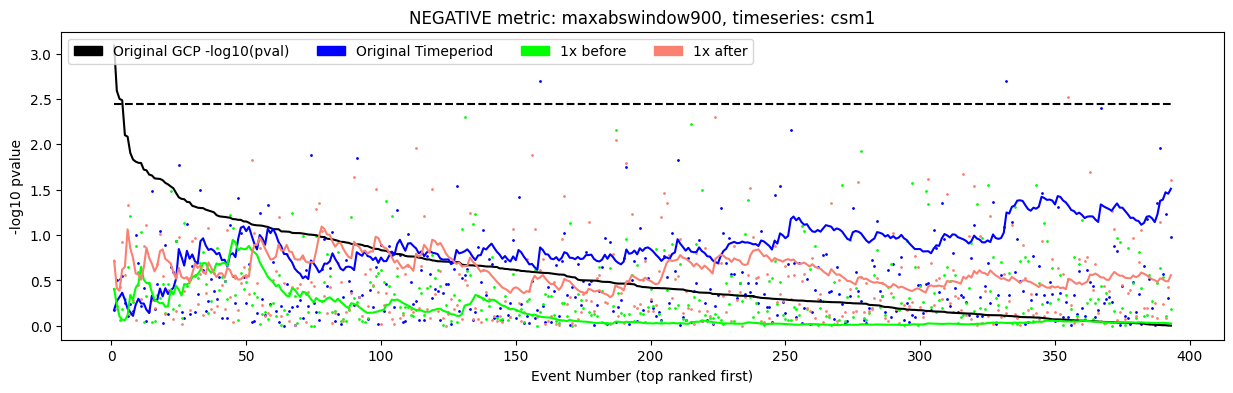

compositez
NEGATIVE maxwindow60
Testing for low meta-analysis p-values:
meta-analysis p-value: Original Timeperiod pval: 0.19556088782243553
Rankbias p-value: Original Timeperiod pval: 0.6699570065891891
meta-analysis p-value: 1x before pval: 0.35332933413317336
Rankbias p-value: 1x before pval: 0.6510219260119383
meta-analysis p-value: 1x after pval: 0.6992601479704059
Rankbias p-value: 1x after pval: 0.7895880641488329


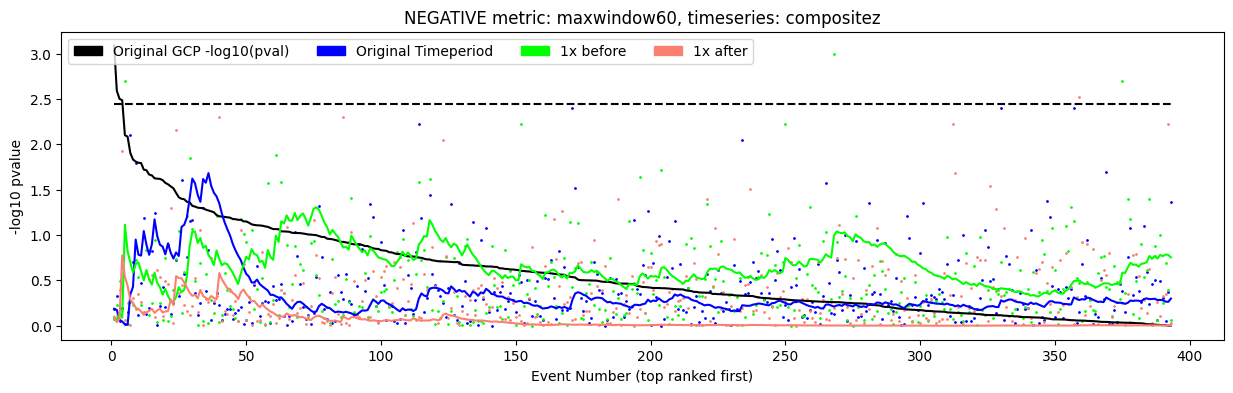

NEGATIVE maxwindow300
Testing for low meta-analysis p-values:
meta-analysis p-value: Original Timeperiod pval: 0.46170765846830636
Rankbias p-value: Original Timeperiod pval: 0.5171565609340751
meta-analysis p-value: 1x before pval: 0.42551489702059586
Rankbias p-value: 1x before pval: 0.4826610282571448
meta-analysis p-value: 1x after pval: 0.34673065386922614
Rankbias p-value: 1x after pval: 0.8844736202609731


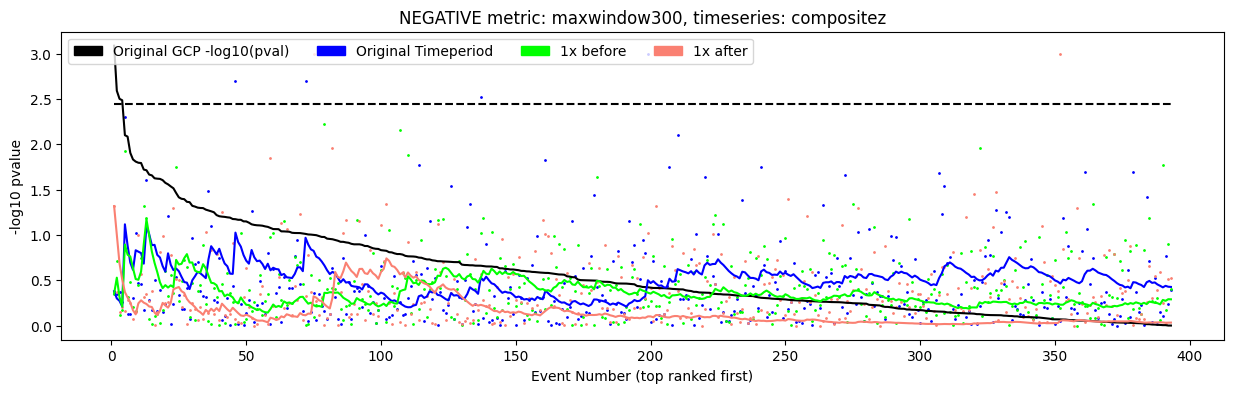

NEGATIVE maxwindow600
Testing for low meta-analysis p-values:
meta-analysis p-value: Original Timeperiod pval: 0.6174765046990601
Rankbias p-value: Original Timeperiod pval: 0.6414931336866735
meta-analysis p-value: 1x before pval: 0.2985402919416117
Rankbias p-value: 1x before pval: 0.7702134112337304
meta-analysis p-value: 1x after pval: 0.5220955808838232
Rankbias p-value: 1x after pval: 0.662465112221877


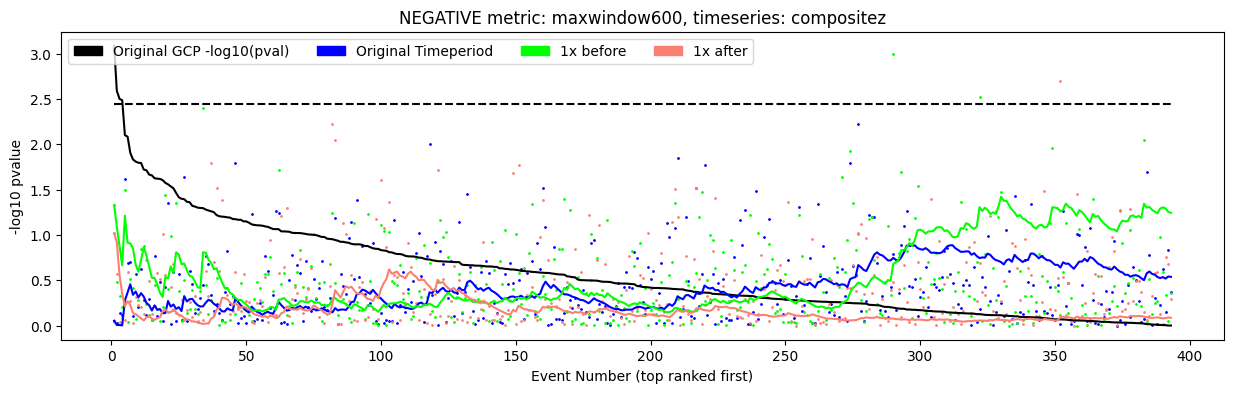

NEGATIVE maxwindow900
Testing for low meta-analysis p-values:
meta-analysis p-value: Original Timeperiod pval: 0.8060387922415517
Rankbias p-value: Original Timeperiod pval: 0.6041330573356817
meta-analysis p-value: 1x before pval: 0.6354729054189162
Rankbias p-value: 1x before pval: 0.7954807837402282
meta-analysis p-value: 1x after pval: 0.8368326334733054
Rankbias p-value: 1x after pval: 0.3425656056453878


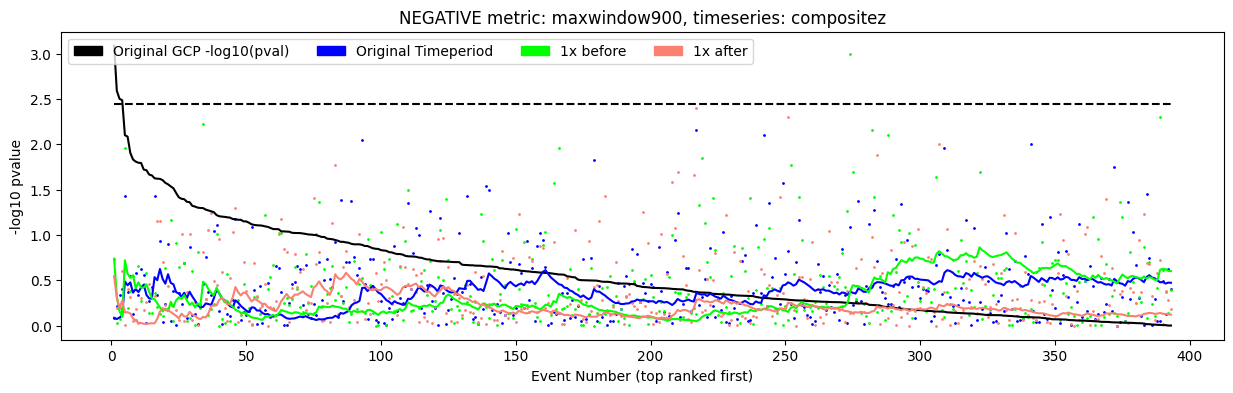

NEGATIVE maxabswindow60
Testing for low meta-analysis p-values:
meta-analysis p-value: Original Timeperiod pval: 0.9276144771045791
Rankbias p-value: Original Timeperiod pval: 0.6658029801329777
meta-analysis p-value: 1x before pval: 0.266746650669866
Rankbias p-value: 1x before pval: 0.5012780082478367
meta-analysis p-value: 1x after pval: 0.5226954609078184
Rankbias p-value: 1x after pval: 0.5504375354190972


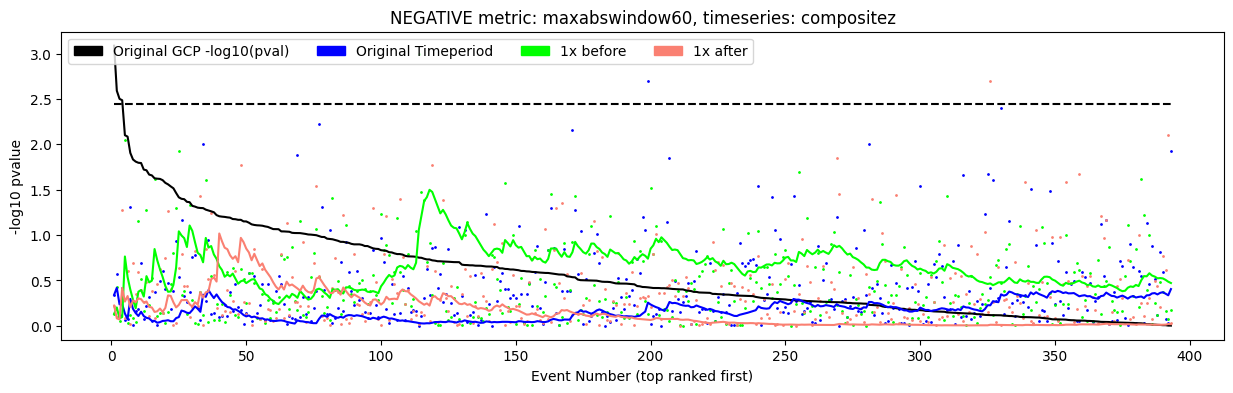

NEGATIVE maxabswindow300
Testing for low meta-analysis p-values:
meta-analysis p-value: Original Timeperiod pval: 0.21755648870225955
Rankbias p-value: Original Timeperiod pval: 0.658274829084074
meta-analysis p-value: 1x before pval: 0.7340531893621276
Rankbias p-value: 1x before pval: 0.7027192710816208
meta-analysis p-value: 1x after pval: 0.4999000199960008
Rankbias p-value: 1x after pval: 0.3979843601153892


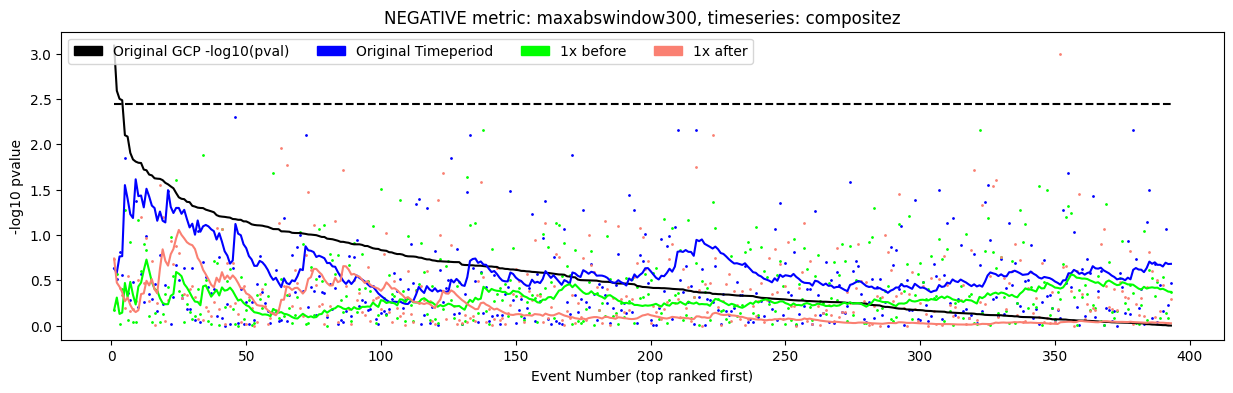

NEGATIVE maxabswindow600
Testing for low meta-analysis p-values:
meta-analysis p-value: Original Timeperiod pval: 0.3817236552689462
Rankbias p-value: Original Timeperiod pval: 0.7889272084637734
meta-analysis p-value: 1x before pval: 0.9220155968806238
Rankbias p-value: 1x before pval: 0.9554907468802623
meta-analysis p-value: 1x after pval: 0.7266546690661868
Rankbias p-value: 1x after pval: 0.05963854262456054


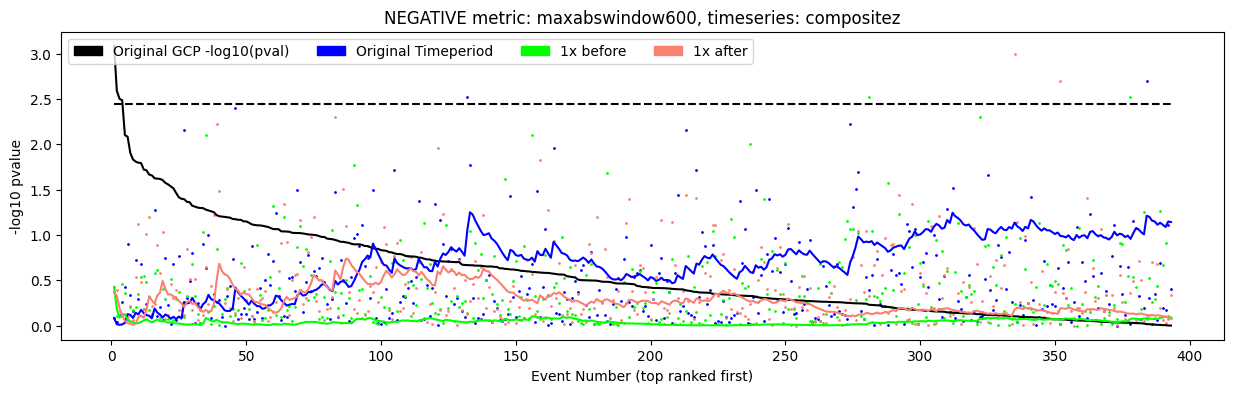

NEGATIVE maxabswindow900
Testing for low meta-analysis p-values:
meta-analysis p-value: Original Timeperiod pval: 0.6154769046190761
Rankbias p-value: Original Timeperiod pval: 0.5014605788627058
meta-analysis p-value: 1x before pval: 0.6442711457708459
Rankbias p-value: 1x before pval: 0.5339175920465226
meta-analysis p-value: 1x after pval: 0.5752849430113978
Rankbias p-value: 1x after pval: 0.3134776439950369


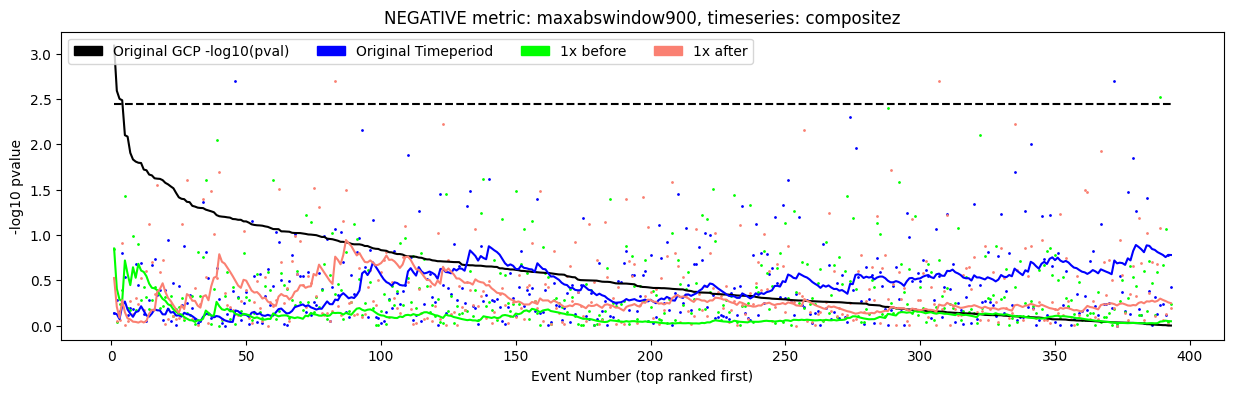

In [8]:
spannames = ['test', 'control1', 'control2']#, 'control3', 'control4', 'control5', 'control6']
loa_names = ['Original Timeperiod', '1x before', '1x after']#, '2x before', '2x after', '3x before', '3x after']
loa_colors = ['blue', 'lime', 'salmon']#, 'forestgreen', 'red', 'darkgreen', 'darkred']

all_metatrendplot_pvals = []

windows = ['60', '300', '600', '900']
for signalname, pvals in [('csm1', csm1_psanalysis),
                          ('compositez', compositez_psanalysis)
                          ]:
  print(signalname)
  for metricname in (['maxwindow'+x for x in windows]+
                     ['maxabswindow'+x for x in windows]):
    print(metricname)
    pval_for_trendplots_list = make_meta_trend_plot(
      "metric: "+metricname+", timeseries: "+signalname,
      uncorrected_pvals_loa=[np.array([x["pval_"+metricname] for x in pvals[y]])
                             for y in spannames],
      loa_names=loa_names,
      loa_colors=loa_colors)
    for arr_name, pval in zip(loa_names, pval_for_trendplots_list):
      all_metatrendplot_pvals.append( ("span:"+arr_name+"; signal:"+signalname+"; metric:"+metricname,
                                       pval) )

for signalname, pvals in [('csm1', csm1_psanalysis),
                          ('compositez', compositez_psanalysis)
                          ]:
  print(signalname)
  npersegvals = ['NA', '60min']
  for metricname in (['maxwindow'+x for x in windows]+
                     ['maxabswindow'+x for x in windows]):
    print("NEGATIVE", metricname)
    pval_for_trendplots_list = make_meta_trend_plot(
      "NEGATIVE metric: "+metricname+", timeseries: "+signalname,
      uncorrected_pvals_loa=[(1-np.array([x["pval_"+metricname] for x in pvals[y]]))
                             for y in spannames],
      loa_names=loa_names,
      loa_colors=loa_colors)
    for arr_name, pval in zip(loa_names, pval_for_trendplots_list):
      all_metatrendplot_pvals.append( ("span:"+arr_name+"; signal:"+signalname+"; metric:"+"negative-"+metricname,
                                       pval) )


In [9]:
[(x[0], x[1], (x[1]*len(all_metatrendplot_pvals) )/(i+1) )
  for (i,x) in enumerate(sorted(all_metatrendplot_pvals, key=lambda x: x[1]))]


[('span:1x before; signal:csm1; metric:maxwindow60',
  0.010997800439912017,
  1.0557888422315536),
 ('span:1x before; signal:csm1; metric:maxabswindow60',
  0.010997800439912017,
  0.5278944211157768),
 ('span:Original Timeperiod; signal:csm1; metric:negative-maxwindow60',
  0.015796840631873626,
  0.505498900219956),
 ('span:Original Timeperiod; signal:csm1; metric:negative-maxabswindow60',
  0.015796840631873626,
  0.379124175164967),
 ('span:1x after; signal:compositez; metric:maxwindow60',
  0.020795840831833633,
  0.39928014397120576),
 ('span:1x after; signal:compositez; metric:maxabswindow60',
  0.03239352129574085,
  0.5182963407318536),
 ('span:1x after; signal:compositez; metric:maxabswindow300',
  0.14417116576684663,
  1.9772045590881824),
 ('span:1x after; signal:compositez; metric:maxwindow300',
  0.16356728654269145,
  1.9628074385122973),
 ('span:Original Timeperiod; signal:compositez; metric:negative-maxwindow60',
  0.19556088782243553,
  2.0859828034393124),
 ('span: